# Classification

When we are trying to predict if something will happen or not, we have entered the realm of **classification**. In this example, we are going to look at only two possible outcome classes from our customer dataset we have been using: "big spender" or "not big spender". The data is the file `./data/customers_clean.csv`.

In [1]:
# Import our most-used packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

# We'll use a DummyClassifier for fun
from sklearn.dummy import DummyClassifier

# Logistic Regression modules
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression

# Need to measure "goodness"
# Need to measure "goodness"
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, average_precision_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

# Scaling
from sklearn.preprocessing import StandardScaler

In [2]:
# Read in the data and print out its shape
cust = pd.read_csv('./data/customers_clean.csv')
print(cust.shape)

(12266, 11)


In [3]:
# See summary statistics
cust.describe()

,age,household_income,num_children,num_vehicles,spend
count,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000
mean,37.864096,301670.381135,2.505544,2.503913,4531.936736
std,10.663234,115752.377718,1.707281,1.697419,1597.594658
min,20.000000,65003.000000,0.000000,0.000000,1468.000000
25%,29.000000,217028.250000,1.000000,1.000000,3237.000000
50%,38.000000,307364.500000,3.000000,3.000000,4766.000000
75%,47.000000,399456.250000,4.000000,4.000000,5723.000000
max,56.000000,489982.000000,5.000000,5.000000,7500.000000


In [4]:
# Let's drop the following columns:
# cust_id, join_date, last_purchase_date
new_cust = cust.drop(columns=['cust_id','join_date','last_purchase_date'])
new_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12266 entries, 0 to 12265
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            12266 non-null  object
 1   age               12266 non-null  int64 
 2   marital_status    12266 non-null  object
 3   household_income  12266 non-null  int64 
 4   home_ownership    12266 non-null  object
 5   num_children      12266 non-null  int64 
 6   num_vehicles      12266 non-null  int64 
 7   spend             12266 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 766.8+ KB


In [5]:
# Create dummies and save in new DataFrame
data = pd.get_dummies(new_cust, dtype=int, drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12266 entries, 0 to 12265
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   age                       12266 non-null  int64
 1   household_income          12266 non-null  int64
 2   num_children              12266 non-null  int64
 3   num_vehicles              12266 non-null  int64
 4   spend                     12266 non-null  int64
 5   gender_M                  12266 non-null  int64
 6   marital_status_unmarried  12266 non-null  int64
 7   home_ownership_rent       12266 non-null  int64
 8   home_ownership_unknown    12266 non-null  int64
dtypes: int64(9)
memory usage: 862.6 KB


## Create "big spender"

We want to convert the $y$ variable, `spend`, into a binary variable where 1 represents a big spender and a 0 otherwise. We can set the cutoff anywhere we want. Looking at the summary statistics from above, let's use \$5,700 as the cutoff. We can use the function `pd.cut()`.

In [6]:
# Try it to see how many will be "big spenders"
pd.cut(data.spend, bins=[0,4700,10000], right=True).value_counts()

spend
(4700, 10000]    6320
(0, 4700]        5946
Name: count, dtype: int64

In [7]:
data['big_spender'] = pd.cut(data.spend, bins=[0,4700,10000], right=True, labels=[0,1]).astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12266 entries, 0 to 12265
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   age                       12266 non-null  int64
 1   household_income          12266 non-null  int64
 2   num_children              12266 non-null  int64
 3   num_vehicles              12266 non-null  int64
 4   spend                     12266 non-null  int64
 5   gender_M                  12266 non-null  int64
 6   marital_status_unmarried  12266 non-null  int64
 7   home_ownership_rent       12266 non-null  int64
 8   home_ownership_unknown    12266 non-null  int64
 9   big_spender               12266 non-null  int64
dtypes: int64(10)
memory usage: 958.4 KB


In [8]:
# See summary statistics
data.describe()

,age,household_income,num_children,num_vehicles,spend,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown,big_spender
count,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000
mean,37.864096,301670.381135,2.505544,2.503913,4531.936736,0.315669,0.251834,0.252323,0.101582,0.515245
std,10.663234,115752.377718,1.707281,1.697419,1597.594658,0.464801,0.434084,0.434364,0.302110,0.499788
min,20.000000,65003.000000,0.000000,0.000000,1468.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,217028.250000,1.000000,1.000000,3237.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,307364.500000,3.000000,3.000000,4766.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,47.000000,399456.250000,4.000000,4.000000,5723.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,56.000000,489982.000000,5.000000,5.000000,7500.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: xlabel='household_income', ylabel='big_spender'>

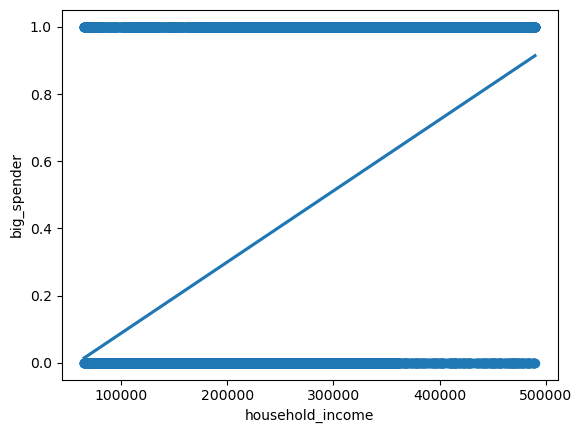

In [9]:
# Let's try something crazy ... let's fit an OLS model to the data
# Plot it to see what it looks like
#
# Plot household_income on x-axis and big_spender on the y-axis, add regression line
sns.regplot(x='household_income', y='big_spender', data=data, ci=None)

In [10]:
# Visually we saw issues with the OLS fitted line
# This is why we use logistic regression
# There is a logit() function statsmodels.formula.api
logitResults = smf.logit('big_spender ~ household_income', data=data).fit()
logitResults.summary()

Optimization terminated successfully.
         Current function value: 0.560858
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            big_spender   No. Observations:                12266
Model:                          Logit   Df Residuals:                    12264
Method:                           MLE   Df Model:                            1
Date:                Tue, 26 Sep 2023   Pseudo R-squ.:                  0.1903
Time:                        19:49:10   Log-Likelihood:                -6879.5
converged:                       True   LL-Null:                       -8496.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.0499      0.067    -45.566      0.000      -3.181      -2.919
household_income   1.03e-05    2.1e-07     49.147      0.000    9.89e-06    1.07e-05
====================================================================================
"""

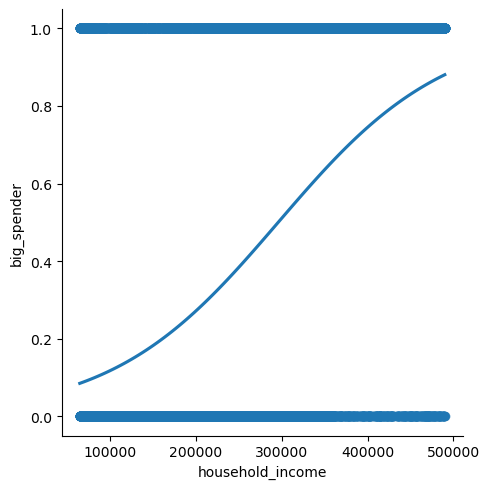

In [11]:
# Output at top different than OLS
# Coefficients table useful for p-values and for predictions
# Let's plot the logistic regression model
# Turn OFF the confidence interval, otherwise it take time to run
sns.lmplot(x='household_income', y='big_spender', data=data,
          logistic=True, ci=None)

## Split Data into Training and Test Sets

Need to first define `X` and `y`. Then we can try train/test split.

In [12]:
# define the output variable, y
y = data.big_spender

# define the X
X = data.drop(columns=['spend', 'big_spender', 'age', 'num_children', 'num_vehicles'])

In [13]:
# Time to split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=163)

In [14]:
# What is the percentage of big spenders in both training and test?
print(f'Training percentage of big spenders is {y_train.mean():.2%}')
print(f'Testing percentage of big spenders is  {y_test.mean():.2%}')

Training percentage of big spenders is 50.87%
Testing percentage of big spenders is  54.16%


## Statification

You can use stratification based on the `y` variable to get approximately the same number of big spenders in both the training set and the test set.

In [15]:
# Time to split the data into training and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=163,
                                                       stratify=y)

# What is the percentage of big spenders in both training and test?
print(f'Training percentage of big spenders is {y_train2.mean():.2%}')
print(f'Testing percentage of big spenders is  {y_test2.mean():.2%}')

Training percentage of big spenders is 51.53%
Testing percentage of big spenders is  51.51%


**Not** going to use the stratified split.

In [16]:
# Fit the scaler on just the training X variables
# Let's start with StandardScaler which will center
# each variable at 0 and give each a unit variance (=1)
s_scaler = StandardScaler().fit(X_train)
s_scaler

StandardScaler()

In [17]:
# Transform X_train and put in DataFrame
X_train_ss = pd.DataFrame(s_scaler.transform(X_train), columns=X_train.columns)

In [18]:
# Take a look at the DataFrame
X_train_ss.describe()

,household_income,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown
count,9.812000e+03,9.812000e+03,9.812000e+03,9.812000e+03,9.812000e+03
mean,-1.578662e-16,-4.127694e-17,6.752763e-17,-5.630320e-17,-1.375898e-17
std,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00
min,-2.053426e+00,-6.788013e-01,-5.795470e-01,-5.842546e-01,-3.310260e-01
25%,-7.266243e-01,-6.788013e-01,-5.795470e-01,-5.842546e-01,-3.310260e-01
50%,4.409943e-02,-6.788013e-01,-5.795470e-01,-5.842546e-01,-3.310260e-01
75%,8.439403e-01,1.473185e+00,1.725486e+00,1.711583e+00,-3.310260e-01
max,1.642012e+00,1.473185e+00,1.725486e+00,1.711583e+00,3.020911e+00


In [19]:
# Transform X_test and put in DataFrame
X_test_ss = pd.DataFrame(s_scaler.transform(X_test), columns=X_test.columns)
X_test_ss.describe()

,household_income,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown
count,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000
mean,0.022660,0.002573,0.004695,-0.024796,0.047330
std,1.032056,1.001222,1.002880,0.985813,1.060911
min,-2.051661,-0.678801,-0.579547,-0.584255,-0.331026
25%,-0.746133,-0.678801,-0.579547,-0.584255,-0.331026
50%,0.098260,-0.678801,-0.579547,-0.584255,-0.331026
75%,0.898707,1.473185,1.725486,-0.584255,-0.331026
max,1.641855,1.473185,1.725486,1.711583,3.020911


# DummyClassifier

Let's create a `DummyClassifier` where we will predict the most frequently occurring class, **not** a big spender. How good do you expect this model to be?

In [20]:
# Create a DummyClassifier with constant strategy
dummy = DummyClassifier(strategy='constant', constant=0)
# Fit it to the training set
dummy.fit(X_train_ss, y_train)

DummyClassifier(constant=0, strategy='constant')

In [21]:
# Call predict on the test set
dummy.predict(X_test_ss)

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
# Can 'score' the dummy classifier for test set
dummy.score(X_test_ss, y_test)

0.45843520782396086

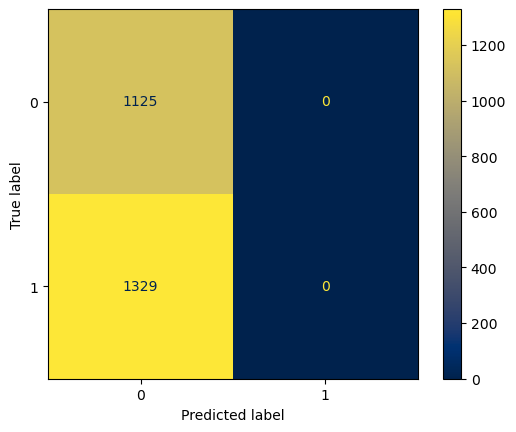

In [23]:
# Create a confusion matrix display
ConfusionMatrixDisplay.from_estimator(dummy, X_test_ss, y_test, cmap='cividis')

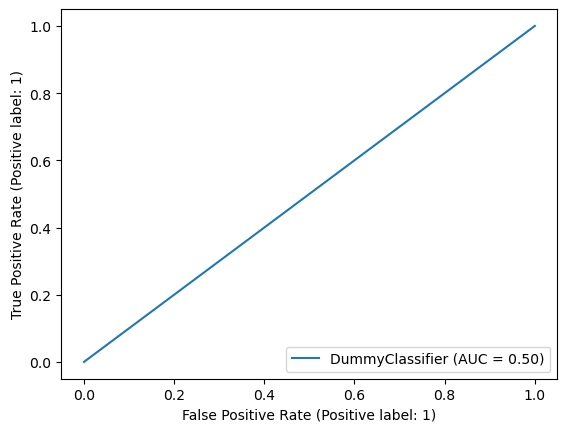

In [24]:
# Create an ROC Curve display
RocCurveDisplay.from_estimator(dummy, X_test_ss, y_test)

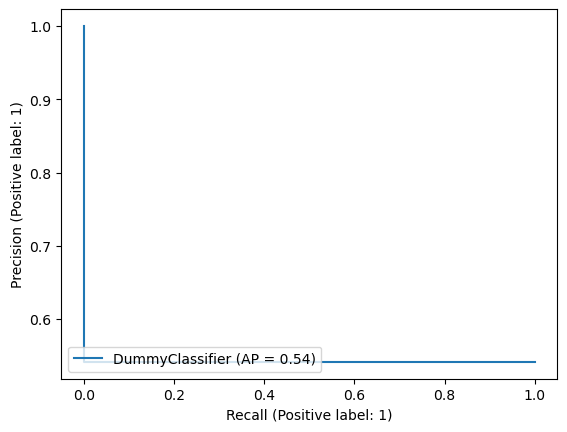

In [25]:
# Create a Precision Recall Display
PrecisionRecallDisplay.from_estimator(dummy, X_test_ss, y_test)

# Create a Logistic Model

Let's first create a logistic model with no scaling. We will then scale the data later and see if it helps with prediction.

In [26]:
log_no_scale = LogisticRegression()

In [28]:
# fit the logistic regression model
log_no_scale.fit(X_train, y_train)

LogisticRegression()

In [29]:
# Print out the estimated intercept and coefficients
print(log_no_scale.intercept_)
print(log_no_scale.coef_)

[-6.2424801e-12]
[[ 1.21059732e-06 -2.94928899e-12 -2.65667262e-12 -2.14399857e-12
  -9.97992732e-13]]


In [30]:
# Make probability predictions for test set
log_no_scale.predict_proba(X_test)

array([[0.44478917, 0.55521083],
       [0.3801431 , 0.6198569 ],
       [0.3992015 , 0.6007985 ],
       ...,
       [0.42070328, 0.57929672],
       [0.39508722, 0.60491278],
       [0.38027632, 0.61972368]])

In [31]:
# We can also get the predicted class for test set
log_no_scale.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

In [32]:
# Print out the confusion matrix
confusion_matrix(y_test, log_no_scale.predict(X_test))

array([[   0, 1125],
       [   0, 1329]])

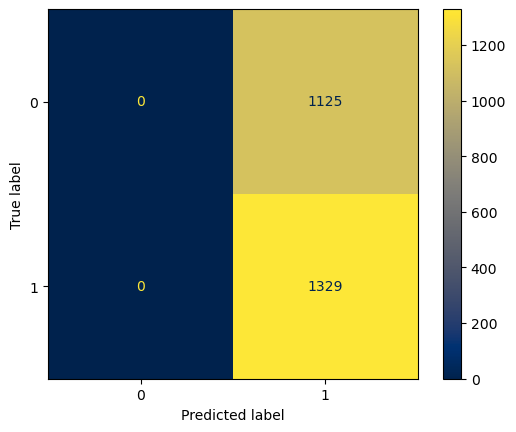

In [33]:
# Let's make a plot of confusion matrix
ConfusionMatrixDisplay.from_estimator(log_no_scale, X_test, y_test, cmap='cividis')

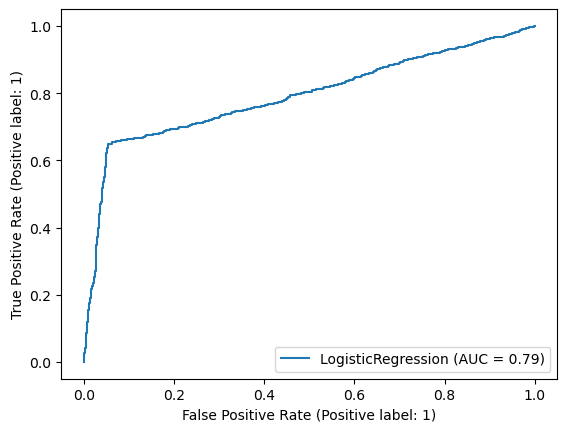

In [34]:
# Create an ROC Curve display
RocCurveDisplay.from_estimator(log_no_scale, X_test, y_test)

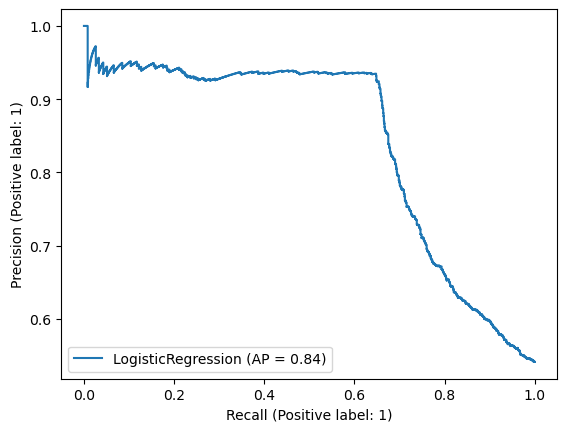

In [35]:
# Make a Precision Recall display
PrecisionRecallDisplay.from_estimator(log_no_scale, X_test, y_test)

## Scaled Logit

In [36]:
# Create a LogisticRegression
logReg = LogisticRegression()

In [37]:
# fit the logistic regression model
logReg.fit(X_train_ss, y_train)

LogisticRegression()

In [38]:
# Print out the estimated intercept and coefficients
print(logReg.intercept_)
print(logReg.coef_)

[0.02804189]
[[1.22465032 0.05527178 0.01138479 0.09535785 0.04585716]]


In [39]:
# Make probability predictions for test set
logReg.predict_proba(X_test_ss)

array([[0.78869343, 0.21130657],
       [0.22688452, 0.77311548],
       [0.38799412, 0.61200588],
       ...,
       [0.5649062 , 0.4350938 ],
       [0.38859913, 0.61140087],
       [0.26853108, 0.73146892]])

In [40]:
# We can also get the predicted class for test set
logReg.predict(X_test_ss)

array([0, 1, 1, ..., 0, 1, 1])

In [41]:
# Print out the confusion matrix
confusion_matrix(y_test, logReg.predict(X_test_ss))

array([[787, 338],
       [358, 971]])

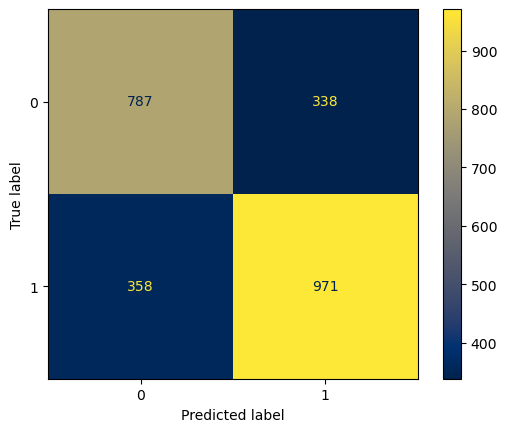

In [42]:
# Let's make a plot of confusion matrix
ConfusionMatrixDisplay.from_estimator(logReg, X_test_ss, y_test, cmap='cividis')

In [43]:
# We can "unravel" the values in confusion matrix with .ravel()
trueNeg, falsePos, falseNeg, truePos = confusion_matrix(y_test, logReg.predict(X_test_ss)).ravel()

print(f'trueNeg : {trueNeg:>4}')
print(f'falsePos: {falsePos:>4}')
print(f'falseNeg: {falseNeg:>4}')
print(f'truePos : {truePos:>4}')

trueNeg :  787
falsePos:  338
falseNeg:  358
truePos :  971


In [44]:
# Let's first look at the overall error rate and accuracy
# Overall error rate = total misclassifications / total chances (sample size)
print(f'Overall Error Rate: {(falseNeg+falsePos)/len(y_test):>6.2%}')
print(f'Overall Accuracy  : {(trueNeg+truePos)/len(y_test):>6.2%}')

Overall Error Rate: 28.36%
Overall Accuracy  : 71.64%


In [45]:
# Let's look at error rates
# Find the number of big spenders and others
bigSpenders = y_test.sum()
others = len(y_test) - bigSpenders
print(f'# of big spenders: {bigSpenders}')
print(f'# of others      : {others}')

# of big spenders: 1329
# of others      : 1125


In [46]:
# How good are we with others? We misclassified XX others
# Error rate = false positives / total non-defaulters
print(f'Error rate for others: {falsePos/others:>6.2%}')
# Accuracy for others = true negatives / total non-defaulters
print(f'Accuracy for others  : {trueNeg/others:>6.2%}')

Error rate for others: 30.04%
Accuracy for others  : 69.96%


In [47]:
# What about big spenders?
# Error rate for big spenders = false negatives / total defaulters
print(f'Error rate for big spenders: {falseNeg/bigSpenders:>6.2%}')
# Accuracy for defaulters = true positives / total defaulters
print(f'Accuracy for big spenders  : {truePos/bigSpenders:>6.2%}')

Error rate for big spenders: 26.94%
Accuracy for big spenders  : 73.06%


In [48]:
# Print the classification_report
print(classification_report(y_test, logReg.predict(X_test_ss), target_names=['No','Yes']))

              precision    recall  f1-score   support

          No       0.69      0.70      0.69      1125
         Yes       0.74      0.73      0.74      1329

    accuracy                           0.72      2454
   macro avg       0.71      0.72      0.71      2454
weighted avg       0.72      0.72      0.72      2454



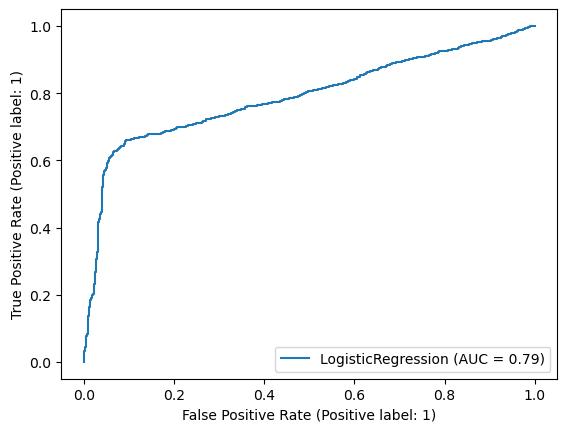

In [49]:
# Create an ROC Curve display
RocCurveDisplay.from_estimator(logReg, X_test_ss, y_test)

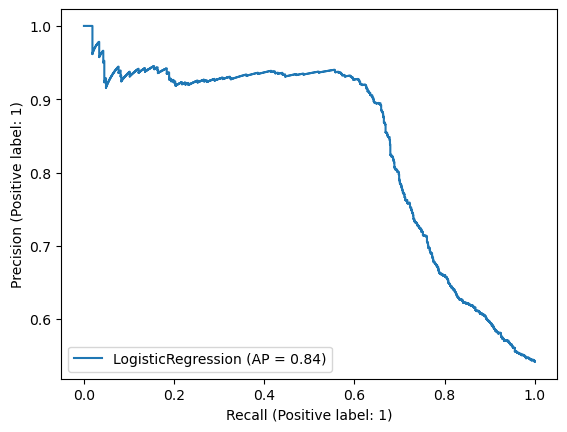

In [50]:
# Make a Precision Recall display
PrecisionRecallDisplay.from_estimator(logReg, X_test_ss, y_test)